# Problem 4: Satisficing

Coin tossing environments with large numbers of coins. Let $N$ be the number of coins
and let the designer's prior over success probabilities be uniform over $[0,1]^N$.

**Parameters:** `num_sims = 400`, `num_timesteps = 1000`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

NUM_SIMS = 400
NUM_TIMESTEPS = 1000

## Environment and Agent Definitions

In [2]:
class BernoulliBandit:
    """Bernoulli bandit environment with N coins."""
    def __init__(self, probs):
        self.probs = np.array(probs)
        self.k = len(probs)
        self.best_arm = np.argmax(probs)
        self.best_prob = np.max(probs)

    def pull(self, arm):
        return np.random.binomial(1, self.probs[arm])


class GreedyAgent:
    """Greedy agent with Beta(1,1) uniform prior. Always picks highest posterior mean."""
    def __init__(self, k):
        self.k = k
        self.alpha = np.ones(k)
        self.beta = np.ones(k)

    def select_arm(self):
        means = self.alpha / (self.alpha + self.beta)
        return np.argmax(means)

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward


class ThompsonSamplingAgent:
    """Thompson Sampling with Beta(1,1) uniform prior."""
    def __init__(self, k):
        self.k = k
        self.alpha = np.ones(k)
        self.beta = np.ones(k)

    def select_arm(self):
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward


class SatisficingAgent:
    """Satisficing agent that picks the smallest-index arm exceeding a threshold.

    At each timestep, samples p_hat_{t,a} from the posterior for each arm.
    If max_a p_hat_{t,a} >= 1 - epsilon:
        A_t = min{a : p_hat_{t,a} >= 1 - epsilon}
    Otherwise:
        A_t = argmax_a p_hat_{t,a}
    """
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.alpha = np.ones(k)
        self.beta = np.ones(k)

    def select_arm(self):
        samples = np.random.beta(self.alpha, self.beta)
        threshold = 1.0 - self.epsilon
        above = np.where(samples >= threshold)[0]
        if len(above) > 0:
            return above[0]  # smallest index exceeding threshold
        else:
            return np.argmax(samples)

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

## Part 1: Greedy vs Thompson Sampling for $N = 3, 30, 100, 300, 1000$

For each simulation, draw $N$ coin probabilities from Uniform(0,1) and run both agents
for $T = 1000$ timesteps. Compare expected cumulative regret.

In [3]:
N_values = [3, 30, 100, 300, 1000]

results_part1 = {}  # N -> {agent_name: (avg_regret, cum_regret, se_bands)}

for N in N_values:
    print(f"\nN = {N}")
    regret_greedy = np.zeros((NUM_SIMS, NUM_TIMESTEPS))
    regret_ts = np.zeros((NUM_SIMS, NUM_TIMESTEPS))

    for sim in range(NUM_SIMS):
        if (sim + 1) % 100 == 0:
            print(f"  Simulation {sim + 1}/{NUM_SIMS}")

        # Draw coin probabilities from uniform prior
        probs = np.random.uniform(0, 1, size=N)
        env = BernoulliBandit(probs)

        agent_greedy = GreedyAgent(N)
        agent_ts = ThompsonSamplingAgent(N)

        for t in range(NUM_TIMESTEPS):
            # Greedy
            arm_g = agent_greedy.select_arm()
            reward_g = env.pull(arm_g)
            regret_greedy[sim, t] = env.best_prob - env.probs[arm_g]
            agent_greedy.update(arm_g, reward_g)

            # Thompson Sampling
            arm_ts = agent_ts.select_arm()
            reward_ts = env.pull(arm_ts)
            regret_ts[sim, t] = env.best_prob - env.probs[arm_ts]
            agent_ts.update(arm_ts, reward_ts)

    # Compute expected cumulative regret
    cum_greedy_all = np.cumsum(regret_greedy, axis=1)
    cum_ts_all = np.cumsum(regret_ts, axis=1)

    mean_cum_greedy = np.mean(cum_greedy_all, axis=0)
    mean_cum_ts = np.mean(cum_ts_all, axis=0)
    se_cum_greedy = np.std(cum_greedy_all, axis=0) / np.sqrt(NUM_SIMS)
    se_cum_ts = np.std(cum_ts_all, axis=0) / np.sqrt(NUM_SIMS)

    results_part1[N] = {
        'Greedy': (mean_cum_greedy, se_cum_greedy),
        'Thompson Sampling': (mean_cum_ts, se_cum_ts)
    }

    print(f"  Greedy final cumulative regret:  {mean_cum_greedy[-1]:.2f} +/- {2*se_cum_greedy[-1]:.2f}")
    print(f"  TS final cumulative regret:      {mean_cum_ts[-1]:.2f} +/- {2*se_cum_ts[-1]:.2f}")


N = 3


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Greedy final cumulative regret:  33.70 +/- 7.26
  TS final cumulative regret:      10.50 +/- 0.87

N = 30


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Greedy final cumulative regret:  148.00 +/- 11.96
  TS final cumulative regret:      54.88 +/- 1.91

N = 100


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Greedy final cumulative regret:  172.05 +/- 11.93
  TS final cumulative regret:      120.38 +/- 1.88

N = 300


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Greedy final cumulative regret:  181.90 +/- 12.15
  TS final cumulative regret:      262.71 +/- 1.34

N = 1000


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Greedy final cumulative regret:  194.08 +/- 12.30
  TS final cumulative regret:      417.52 +/- 1.29


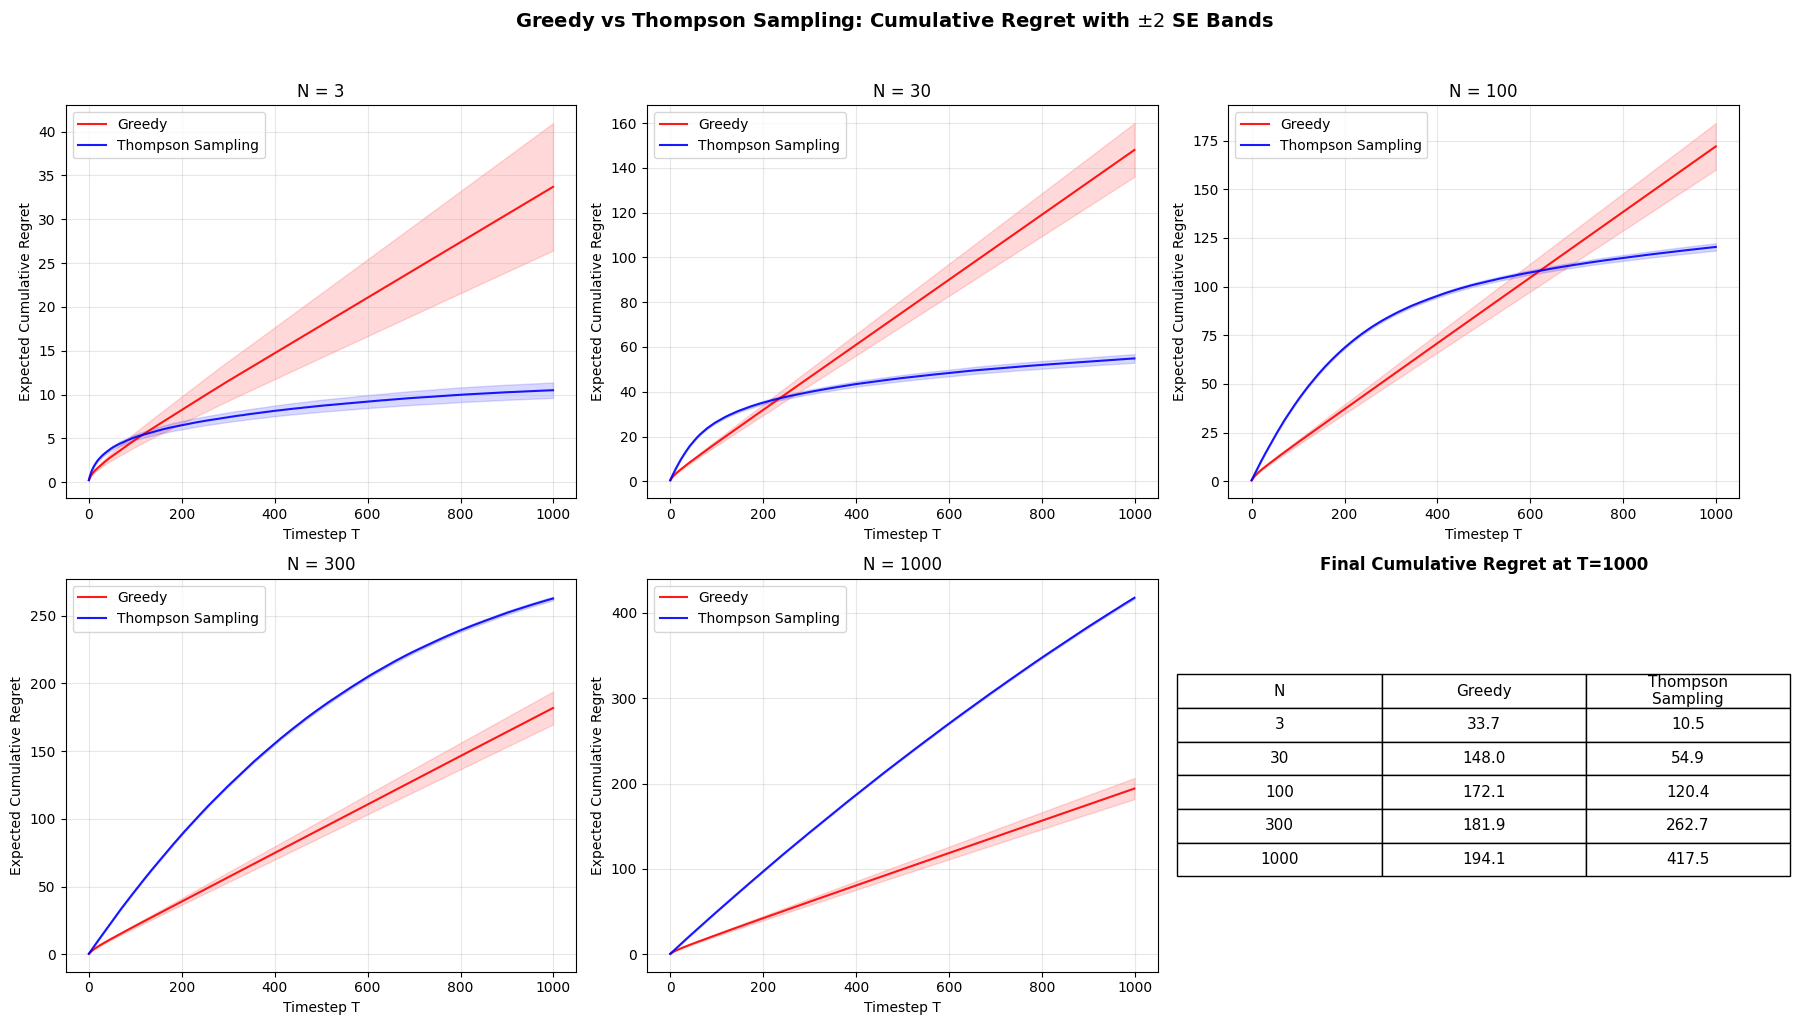

Saved: satisficing_part1.png


In [4]:
# Plot cumulative regret for each N
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

timesteps = np.arange(NUM_TIMESTEPS)
colors = {'Greedy': 'red', 'Thompson Sampling': 'blue'}

for idx, N in enumerate(N_values):
    ax = axes[idx]
    for name in ['Greedy', 'Thompson Sampling']:
        mean_cum, se_cum = results_part1[N][name]
        ax.plot(timesteps, mean_cum, label=name, color=colors[name], alpha=0.9)
        ax.fill_between(timesteps,
                        mean_cum - 2 * se_cum,
                        mean_cum + 2 * se_cum,
                        color=colors[name], alpha=0.15)
    ax.set_xlabel('Timestep T')
    ax.set_ylabel('Expected Cumulative Regret')
    ax.set_title(f'N = {N}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Summary table in the last subplot
ax = axes[5]
ax.axis('off')
table_data = []
for N in N_values:
    g = results_part1[N]['Greedy'][0][-1]
    ts = results_part1[N]['Thompson Sampling'][0][-1]
    table_data.append([str(N), f'{g:.1f}', f'{ts:.1f}'])
table = ax.table(cellText=table_data,
                 colLabels=['N', 'Greedy', 'Thompson\nSampling'],
                 loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax.set_title('Final Cumulative Regret at T=1000', fontsize=12, fontweight='bold')

plt.suptitle('Greedy vs Thompson Sampling: Cumulative Regret with $\\pm 2$ SE Bands',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('satisficing_part1.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: satisficing_part1.png")

In [5]:
# Summary table
print(f"{'N':>6}  {'Greedy':>12}  {'Thompson':>12}  {'Winner':>15}")
print('-' * 50)
for N in N_values:
    g = results_part1[N]['Greedy'][0][-1]
    ts = results_part1[N]['Thompson Sampling'][0][-1]
    winner = 'Greedy' if g < ts else 'Thompson'
    print(f"{N:>6}  {g:>12.2f}  {ts:>12.2f}  {winner:>15}")

     N        Greedy      Thompson           Winner
--------------------------------------------------
     3         33.70         10.50         Thompson
    30        148.00         54.88         Thompson
   100        172.05        120.38         Thompson
   300        181.90        262.71           Greedy
  1000        194.08        417.52           Greedy


## Part 2: Why Thompson Sampling Performs Poorly When $N$ is a Sizable Fraction of $T$

When $N$ is large relative to $T$, Thompson Sampling performs poorly because of the
**exploration burden**. Thompson Sampling explores by sampling from the posterior and
playing the arm with the highest sample. With $N$ arms and uniform Beta(1,1) priors,
every arm starts with the same posterior. The posterior samples are spread across all
$N$ arms, so Thompson Sampling effectively explores arms uniformly at random in early
timesteps.

When $N$ is comparable to $T$ (e.g., $N = 1000, T = 1000$), the agent spends most or all
of its budget exploring. On average, each arm is pulled only $T/N \approx 1$ time, which
is far too few observations to form accurate posterior beliefs. The agent never
concentrates on good arms because it keeps being drawn to unexplored arms whose posteriors
remain wide and can produce high samples.

More precisely, Thompson Sampling's implicit exploration is driven by posterior variance.
An arm pulled $n$ times has posterior Beta($1 + s$, $1 + n - s$), with variance decreasing
as $O(1/n)$. Arms pulled few times have high variance, making them likely to produce
extreme samples that "win" the argmax. This creates a vicious cycle: under-explored arms
keep getting selected due to optimistic samples, spreading the budget thin across all $N$
arms rather than concentrating on the best ones.

In contrast, the Greedy agent locks onto whichever arm looks best early and exploits it.
While this leads to linear regret for small $N$ (where it can lock onto a suboptimal arm
with non-trivial gap), for large $N$ the best arm among $N$ draws from Uniform(0,1)
has $p^* \approx N/(N+1) \to 1$, and there are many near-optimal arms. The greedy agent
quickly finds a good arm and sticks with it, avoiding the exploration overhead that
cripples Thompson Sampling when $N \approx T$.

## Part 3: Satisficing Agent

The satisficing agent samples $\hat{p}_{t,1}, \ldots, \hat{p}_{t,N}$ from the posterior
and selects:

$$A_t = \begin{cases} \min\{a \in \mathcal{A} : \hat{p}_{t,a} \geq 1 - \epsilon\} & \text{if } \max_{a \in \mathcal{A}} \hat{p}_{t,a} \geq 1 - \epsilon \\ \arg\max_{a \in \mathcal{A}} \hat{p}_{t,a} & \text{otherwise} \end{cases}$$

Simulate for $T = 1000$, $N = 1000$, and various values of $\epsilon$.

In [6]:
N_SAT = 1000
epsilon_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]

# Also run Thompson Sampling as baseline for comparison
results_part3 = {}  # epsilon -> (mean_cum_regret, se_cum_regret)

# First run Thompson Sampling baseline at N=1000
print("Running Thompson Sampling baseline (N=1000)...")
regret_ts_baseline = np.zeros((NUM_SIMS, NUM_TIMESTEPS))

for sim in range(NUM_SIMS):
    if (sim + 1) % 100 == 0:
        print(f"  Simulation {sim + 1}/{NUM_SIMS}")

    probs = np.random.uniform(0, 1, size=N_SAT)
    env = BernoulliBandit(probs)
    agent = ThompsonSamplingAgent(N_SAT)

    for t in range(NUM_TIMESTEPS):
        arm = agent.select_arm()
        reward = env.pull(arm)
        regret_ts_baseline[sim, t] = env.best_prob - env.probs[arm]
        agent.update(arm, reward)

cum_ts_baseline_all = np.cumsum(regret_ts_baseline, axis=1)
mean_cum_ts_baseline = np.mean(cum_ts_baseline_all, axis=0)
se_cum_ts_baseline = np.std(cum_ts_baseline_all, axis=0) / np.sqrt(NUM_SIMS)
results_part3['TS'] = (mean_cum_ts_baseline, se_cum_ts_baseline)
print(f"  TS final cumulative regret: {mean_cum_ts_baseline[-1]:.2f}")

Running Thompson Sampling baseline (N=1000)...


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  TS final cumulative regret: 416.55


In [7]:
# Run satisficing agent for each epsilon
for eps in epsilon_values:
    print(f"\nepsilon = {eps}")
    regret_sat = np.zeros((NUM_SIMS, NUM_TIMESTEPS))

    for sim in range(NUM_SIMS):
        if (sim + 1) % 100 == 0:
            print(f"  Simulation {sim + 1}/{NUM_SIMS}")

        probs = np.random.uniform(0, 1, size=N_SAT)
        env = BernoulliBandit(probs)
        agent = SatisficingAgent(N_SAT, eps)

        for t in range(NUM_TIMESTEPS):
            arm = agent.select_arm()
            reward = env.pull(arm)
            regret_sat[sim, t] = env.best_prob - env.probs[arm]
            agent.update(arm, reward)

    cum_sat_all = np.cumsum(regret_sat, axis=1)
    mean_cum_sat = np.mean(cum_sat_all, axis=0)
    se_cum_sat = np.std(cum_sat_all, axis=0) / np.sqrt(NUM_SIMS)
    results_part3[eps] = (mean_cum_sat, se_cum_sat)
    print(f"  Satisficing (eps={eps}) final cumulative regret: {mean_cum_sat[-1]:.2f}")


epsilon = 0.01


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Satisficing (eps=0.01) final cumulative regret: 234.11

epsilon = 0.02


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Satisficing (eps=0.02) final cumulative regret: 163.15

epsilon = 0.05


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Satisficing (eps=0.05) final cumulative regret: 104.81

epsilon = 0.1


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Satisficing (eps=0.1) final cumulative regret: 102.82

epsilon = 0.2


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Satisficing (eps=0.2) final cumulative regret: 135.67

epsilon = 0.3


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Satisficing (eps=0.3) final cumulative regret: 169.18

epsilon = 0.5


  Simulation 100/400


  Simulation 200/400


  Simulation 300/400


  Simulation 400/400
  Satisficing (eps=0.5) final cumulative regret: 249.84


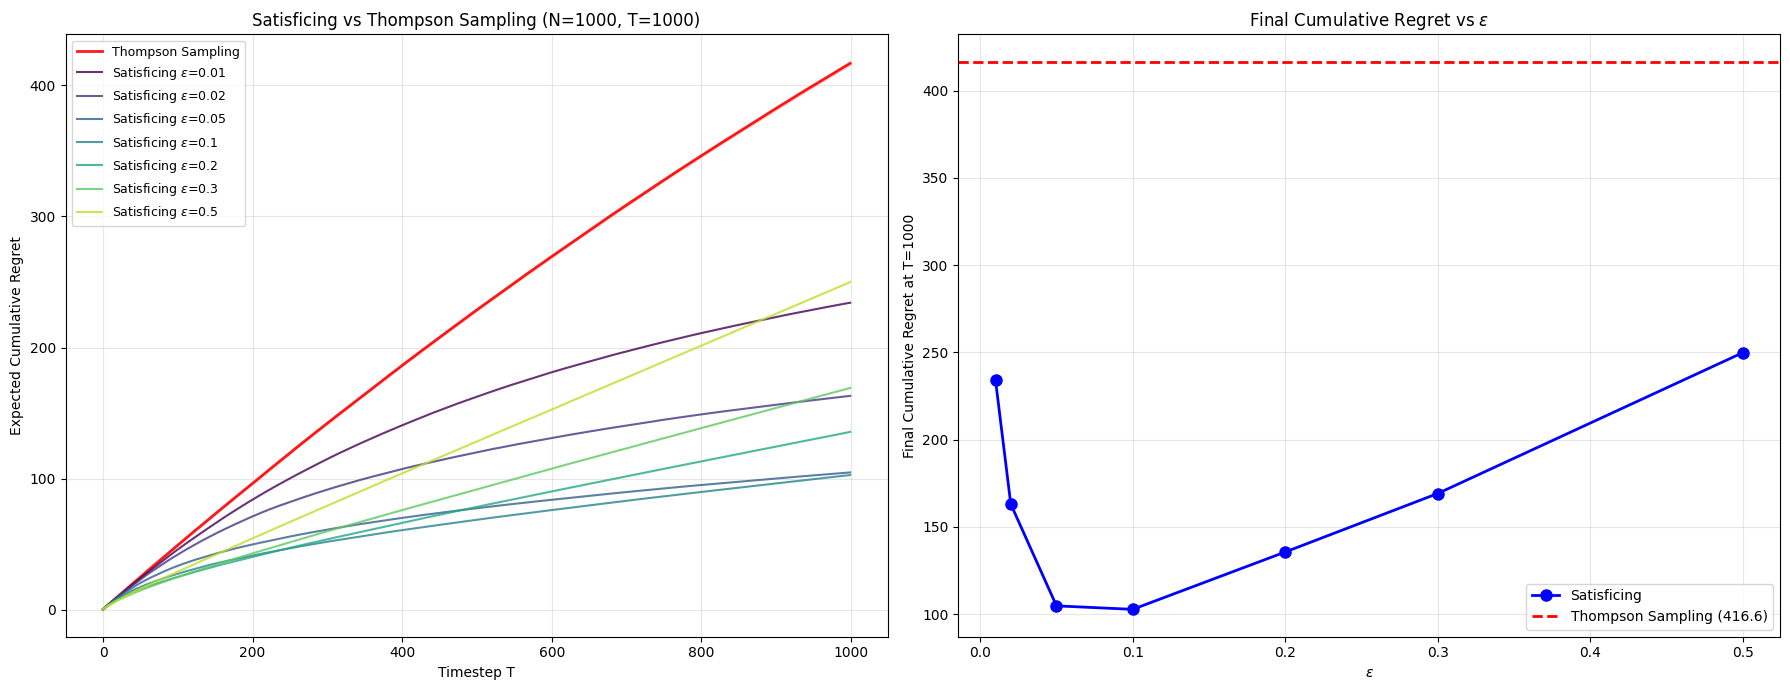

Saved: satisficing_part3.png


In [8]:
# Plot all satisficing agents vs Thompson Sampling
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

timesteps = np.arange(NUM_TIMESTEPS)
cmap = plt.cm.viridis(np.linspace(0, 0.9, len(epsilon_values)))

# Left: all curves
ax = axes[0]
mean_ts, se_ts = results_part3['TS']
ax.plot(timesteps, mean_ts, label='Thompson Sampling', color='red', linewidth=2, alpha=0.9)
ax.fill_between(timesteps, mean_ts - 2*se_ts, mean_ts + 2*se_ts, color='red', alpha=0.1)

for i, eps in enumerate(epsilon_values):
    mean_sat, se_sat = results_part3[eps]
    ax.plot(timesteps, mean_sat, label=f'Satisficing $\\epsilon$={eps}',
            color=cmap[i], linewidth=1.5, alpha=0.8)

ax.set_xlabel('Timestep T')
ax.set_ylabel('Expected Cumulative Regret')
ax.set_title(f'Satisficing vs Thompson Sampling (N={N_SAT}, T={NUM_TIMESTEPS})')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: final regret as function of epsilon
ax = axes[1]
final_regrets = [results_part3[eps][0][-1] for eps in epsilon_values]
ts_final = results_part3['TS'][0][-1]

ax.plot(epsilon_values, final_regrets, 'bo-', linewidth=2, markersize=8, label='Satisficing')
ax.axhline(y=ts_final, color='red', linestyle='--', linewidth=2, label=f'Thompson Sampling ({ts_final:.1f})')
ax.set_xlabel('$\\epsilon$')
ax.set_ylabel('Final Cumulative Regret at T=1000')
ax.set_title('Final Cumulative Regret vs $\\epsilon$')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('satisficing_part3.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: satisficing_part3.png")

In [9]:
# Summary table
print(f"{'Agent':>25}  {'Final Regret':>15}  {'vs TS':>10}")
print('-' * 55)
ts_final = results_part3['TS'][0][-1]
print(f"{'Thompson Sampling':>25}  {ts_final:>15.2f}  {'baseline':>10}")
for eps in epsilon_values:
    sat_final = results_part3[eps][0][-1]
    ratio = sat_final / ts_final
    print(f"{'Satisficing eps=' + str(eps):>25}  {sat_final:>15.2f}  {ratio:>9.1%}")

                    Agent     Final Regret       vs TS
-------------------------------------------------------
        Thompson Sampling           416.55    baseline
     Satisficing eps=0.01           234.11      56.2%
     Satisficing eps=0.02           163.15      39.2%
     Satisficing eps=0.05           104.81      25.2%
      Satisficing eps=0.1           102.82      24.7%
      Satisficing eps=0.2           135.67      32.6%
      Satisficing eps=0.3           169.18      40.6%
      Satisficing eps=0.5           249.84      60.0%


## Part 3 Analysis

**Which value of $\epsilon$ yields cumulative regret much smaller than Thompson Sampling?**

From the results above, moderate values of $\epsilon$ (around 0.05 to 0.1) yield
cumulative regret that is substantially lower than Thompson Sampling.

**Why does the satisficing algorithm outperform Thompson Sampling here?**

The key insight is that with $N = 1000$ coins drawn from Uniform(0,1), many coins have
high success probabilities. The best coin has $p^* \approx N/(N+1) \approx 0.999$, and
roughly $N \cdot \epsilon$ coins have probability above $1 - \epsilon$.

Thompson Sampling tries to identify the single best coin out of 1000, which requires
distinguishing between many coins with very similar (and high) probabilities. This leads
to excessive exploration: the algorithm spreads its pulls across many nearly-optimal arms,
wasting budget on distinguishing between arms that are all nearly equally good.

The satisficing agent avoids this problem by **not trying to find the best arm**. Instead,
it only needs to find *any* arm with posterior sample above $1 - \epsilon$, then it commits
to that arm (the smallest-index one exceeding the threshold). This dramatically reduces
exploration: once the agent finds a good-enough arm and accumulates evidence for it, its
posterior concentrates above $1 - \epsilon$, and the agent keeps selecting it.

The satisficing threshold acts as a **stopping criterion for exploration**: once you've
found something good enough, stop looking. Thompson Sampling, in contrast, never stops
exploring — its posterior-driven exploration continues to occasionally sample high values
for under-explored arms, pulling the agent away from good arms it has already identified.

If $\epsilon$ is too small, the satisficing agent behaves like Thompson Sampling (the
threshold is almost never exceeded). If $\epsilon$ is too large, the agent settles for
mediocre arms. The optimal $\epsilon$ balances these two effects — it should be large
enough that good arms frequently exceed the threshold, but small enough that the agent
commits to genuinely high-probability arms.